# Description

* Quality control on MiSeq run data
  * post-merging
  * post-demultiplexing

# Setting variables

In [1]:
import os

baseDir = '/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib16'
workDir = os.path.join(baseDir, 'QC')
seqFile = os.path.join(baseDir, 'pear_merged-fullCyc2_lib16.assembled.dmult.fastq')

# number of processors
nprocs = 20

# max expected error
maxee = 1

# Init

In [2]:
import re
import pandas as pd

In [3]:
%load_ext rpy2.ipython
#%load_ext pushnote

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:dplyr’:

    combine


  warnings.warn(x, RRuntimeWarning)


In [5]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
%cd $workDir

/home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib16/QC


In [6]:
# symlinking demult seq file into CQ
tmp = os.path.join(baseDir, seqFile)
if not os.path.isfile(seqFile):
    tmp2 = os.path.split(tmp)[1]
    os.symlink(tmp, tmp2)
else:
    print ('File exists: {}'.format(os.path.join(workDir, seqFile)))

File exists: /home/seq_data/fullCyc2/amplicon/515F-806R/final_dataset/library_QC/fullCyc2_lib16/pear_merged-fullCyc2_lib16.assembled.dmult.fastq


# Merged read quality filtering

## Discard sequences that exceed max expected error theshold

In [7]:
qcFile = os.path.split(seqFile)[1]
qcFile = os.path.splitext(qcFile)[0] + '_maxee{}.fasta'.format(maxee)
qcFile

'pear_merged-fullCyc2_lib16.assembled.dmult_maxee1.fasta'

In [8]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

mkdir /home/sam/tmp/tmpdir1
trap "rm -r /home/sam/tmp/tmpdir1" 1 2 3 15
split -d -l 2000000 $1 /home/sam/tmp/tmpdir1/Block

mkdir /home/sam/tmp/tmpdir2
trap "rm -r /home/sam/tmp/tmpdir2" 1 2 3 15
ls /home/sam/tmp/tmpdir1/Block?? | parallel --gnu -j $2 -k "usearch -fastq_filter {} -fastq_maxee $3 \
-fastaout /home/sam/tmp/tmpdir2/{#}.fasta >/dev/null 2>&1 && cat /home/sam/tmp/tmpdir2/{#}.fasta" > $4
rm -r /home/sam/tmp/tmpdir2 /home/sam/tmp/tmpdir1

In [9]:
%%bash -s "$seqFile" "$nprocs" "$maxee" "$qcFile"

printf "Max expected error cutoff: "
echo $3

printf "Number of sequence pre-filter: "
grep -c "orig_name=" $1

printf "Number of sequences post-filter: "
grep -c ">" $4

echo '' 
head -n 8 $4

Max expected error cutoff: 1
Number of sequence pre-filter: 7885567
Number of sequences post-filter: 7859660

>MR.M.13C-Ami.D14.R1_Frac20_0 orig_name=M02465:380:000000000-B887N:1:1101:15622:1331
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCC
CGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTAGGGCAGAGGGTGGTGGAATTTCCTGTGTAGCGGTG
AAATGCGTAGATATCGGAAGGAACATCAGTGGCGAAAGCGACTTCCTGGACCAATACTAACGCTCATGTGCGAAAGCGTG
GGGAGCAAACAGG
>MR.M.13C-Ami.D14.R1_Frac8_1 orig_name=M02465:380:000000000-B887N:1:1101:16072:1335
GACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGTTGTCCAAGTTGGATGTGAAAGCCT
TGAGCTCAACTCAAGAAATGCATTCAGGACTGGGCGGCTAGAGGACCGGAGAGGATAGTGGAATTCCCAGTGTAGTGGTG


## Remove seqs with 'N' characters

In [10]:
qcFile2 = os.path.splitext(qcFile)[0] + '_noN.fasta'
qcFile2

'pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.fasta'

In [11]:
%%bash -s "$qcFile" "$qcFile2"

bioawk -c fastx '{if ($seq !~ /N/){print ">" $name " " $4 "\n" $seq}}' $1 > $2

printf "Number of sequence pre-filter: "
grep -c ">" $1

printf "Number of sequences post-filter: "
grep -c ">" $2

Number of sequence pre-filter: 7859660
Number of sequences post-filter: 7859660


## Alignment-based QC with Mothur

In [12]:
%%bash -s "$qcFile2"
# making mothur group file

perl -ne 'if(/^>/){ s/>(.+)(_\d+) .+/$1$2\t$1/; print;}' $1 > group_file.txt
head group_file.txt

MR.M.13C-Ami.D14.R1_Frac20_0	MR.M.13C-Ami.D14.R1_Frac20
MR.M.13C-Ami.D14.R1_Frac8_1	MR.M.13C-Ami.D14.R1_Frac8
MR.M.13C-Ami.D14.R1_Frac6_2	MR.M.13C-Ami.D14.R1_Frac6
CC.A.151027.H2O-Con.D02_3	CC.A.151027.H2O-Con.D02
BH.F.151026.12C-Xyl.D04_4	BH.F.151026.12C-Xyl.D04
MR.M.13C-Ami.D14.R1_Frac6_6	MR.M.13C-Ami.D14.R1_Frac6
MW.M.151027.12C-Ami.D02_7	MW.M.151027.12C-Ami.D02
MR.M.13C-Ami.D14.R1_Frac7_8	MR.M.13C-Ami.D14.R1_Frac7
CF.F.151027.H2O-Con.D14_9	CF.F.151027.H2O-Con.D14
EL.M.151026.12C-Pal.D28_10	EL.M.151026.12C-Pal.D28


In [13]:
! head -n 200 group_file.txt

MR.M.13C-Ami.D14.R1_Frac20_0	MR.M.13C-Ami.D14.R1_Frac20
MR.M.13C-Ami.D14.R1_Frac8_1	MR.M.13C-Ami.D14.R1_Frac8
MR.M.13C-Ami.D14.R1_Frac6_2	MR.M.13C-Ami.D14.R1_Frac6
CC.A.151027.H2O-Con.D02_3	CC.A.151027.H2O-Con.D02
BH.F.151026.12C-Xyl.D04_4	BH.F.151026.12C-Xyl.D04
MR.M.13C-Ami.D14.R1_Frac6_6	MR.M.13C-Ami.D14.R1_Frac6
MW.M.151027.12C-Ami.D02_7	MW.M.151027.12C-Ami.D02
MR.M.13C-Ami.D14.R1_Frac7_8	MR.M.13C-Ami.D14.R1_Frac7
CF.F.151027.H2O-Con.D14_9	CF.F.151027.H2O-Con.D14
EL.M.151026.12C-Pal.D28_10	EL.M.151026.12C-Pal.D28
MR.M.13C-Ami.D14.R1_Frac5_11	MR.M.13C-Ami.D14.R1_Frac5
CC.A.151027.H2O-Con.D02_12	CC.A.151027.H2O-Con.D02
MR.M.13C-Ami.D14.R1_Frac20_13	MR.M.13C-Ami.D14.R1_Frac20
BH.F.151026.12C-Pal.D28_14	BH.F.151026.12C-Pal.D28
MR.M.13C-Ami.D14.R1_Frac26_15	MR.M.13C-Ami.D14.R1_Frac26
MR.M.13C-Ami.D14.R1_Frac6_16	MR.M.13C-Ami.D14.R1_Frac6
MR.M.13C-Ami.D14.R1_Frac18_17	MR.M.13C-Ami.D14.R1_Frac18
PP.A.151026.H2O-Con.D28_18	PP.A.151026.H2O-Con.D28
MR.M.13C-Ami.D14.R1_Frac11_19	MR.M.13C-Ami.

In [14]:
# unique sequences
cmd = 'mothur "#unique.seqs(fasta={})"'.format(qcFile2)
!$cmd | tail -n 30

7838000	3283036
7839000	3283485
7840000	3283864
7841000	3284272
7842000	3284715
7843000	3285146
7844000	3285577
7845000	3286050
7846000	3286533
7847000	3287080
7848000	3287568
7849000	3288045
7850000	3288505
7851000	3288946
7852000	3289414
7853000	3289915
7854000	3290400
7855000	3290934
7856000	3291469
7857000	3291998
7858000	3292533
7859000	3293075
7859660	3293454

Output File Names: 
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.names
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.fasta


mothur > quit()


In [15]:
qcFile3 = os.path.splitext(qcFile2)[0] + '.unique.fasta'
n_uniq = !grep -c ">" $qcFile3
print ('Number of unique sequences: {}'.format(n_uniq[0]))

Number of unique sequences: 3293454


In [16]:
# name file produced by unique.seqs()
nameFile = os.path.splitext(qcFile2)[0] + '.names'
!ls -thlc $nameFile

-rw-rw-r-- 1 sam sam 349M May 17 08:35 pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.names


In [17]:
%%bash 
# Remove database if already exsists
if [ -d mothur_silva_db ]; then
    rm -rf mothur_silva_db
fi

#if ! [ -d mothur_silva_db ]; then
#    mkdir mothur_silva_db
#fi

mkdir mothur_silva_db
cd mothur_silva_db

# Download mothur recreatd SEED database release 132.
wget https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
#wget https://www.mothur.org/w/images/a/a4/Silva.seed_v128.tgz
tar -xvzf Silva.seed_v132.tgz
rm Silva.seed_v132.tgz

silva.seed_v132.tax
silva.seed_v132.align
README.md


--2018-05-17 08:35:37--  https://www.mothur.org/w/images/7/71/Silva.seed_v132.tgz
Resolving www.mothur.org (www.mothur.org)... 141.214.120.22
Connecting to www.mothur.org (www.mothur.org)|141.214.120.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19623900 (19M) [application/x-gzip]
Saving to: ‘Silva.seed_v132.tgz’

     0K .......... .......... .......... .......... ..........  0% 1.88M 10s
    50K .......... .......... .......... .......... ..........  0%  999K 14s
   100K .......... .......... .......... .......... ..........  0% 1.88M 13s
   150K .......... .......... .......... .......... ..........  1%  990K 14s
   200K .......... .......... .......... .......... ..........  1% 1.88M 14s
   250K .......... .......... .......... .......... ..........  1%  994K 14s
   300K .......... .......... .......... .......... ..........  1% 1.88M 14s
   350K .......... .......... .......... .......... ..........  2%  995K 14s
   400K .......... .......... .......

In [18]:
silvaFile = 'silva.seed_v132.align'
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(silvaFile, nprocs)
!cd mothur_silva_db; $cmd | tail -n 20

silvaFileFilt = os.path.splitext(silvaFile)[0] + '.filter.fasta'
silvaFileFilt = os.path.join('mothur_silva_db', silvaFileFilt)
ret = !grep -c ">" $silvaFileFilt
print ('\nNumber of sequences post-filter: {}'.format(ret[0]))

100
200
300
400
500
560



Length of filtered alignment: 10180
Number of columns removed: 39820
Length of the original alignment: 50000
Number of sequences used to construct filter: 11180

Output File Names: 
silva.filter
silva.seed_v132.filter.fasta


mothur > quit()

Number of sequences post-filter: 11180


In [19]:
# aligning sequences
qcFile3a = re.sub('-', '\-', qcFile3)
cmd = 'mothur "#align.seqs(candidate={}, template={}, processors={}, flip=T)"'.format(qcFile3a, silvaFileFilt, nprocs)
!$cmd | tail -n 30

164500
164600
164700
164800
164900
165000
165100
165200
165300
165308
[WARNING]: Some of your sequences generated alignments that eliminated too many bases, a list is provided in pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.flip.accnos. If the reverse compliment proved to be better it was reported.
It took 1256 secs to align 3293454 sequences.


Output File Names: 
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.align
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.align.report
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.flip.accnos


mothur > quit()


<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Detected 1 [WARNING] messages, please review.
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<^

In [20]:
qcFile4 = os.path.splitext(qcFile3)[0] + '.align'
!ls -thlc $qcFile4 

-rw-rw-r-- 1 sam sam 32G May 17 08:56 pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.align


In [21]:
# filtering out gap positions in the alignment
qcFile4a = re.sub('-', '\-', qcFile4)
cmd = 'mothur "#filter.seqs(vertical=t, fasta={}, processors={})"'.format(qcFile4a, nprocs)
!$cmd | tail -n 30

163200
163300
163400
163500
163600
163700
163800
163900
164000
164100
164200
164300
164400
164500
164600
164693



Length of filtered alignment: 1329
Number of columns removed: 8851
Length of the original alignment: 10180
Number of sequences used to construct filter: 3293454

Output File Names: 
pear_merged-fullCyc2_lib16.filter
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.fasta


mothur > quit()


In [22]:
qcFile5 = os.path.splitext(qcFile3)[0] + '.filter.fasta'
!ls -thlc $qcFile5

-rw-rw-r-- 1 sam sam 4.2G May 17 08:58 pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.fasta


In [23]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={}, name={})"'.format(qcFile5, nprocs, nameFile)
!$cmd | tail -n 20

Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	0	0	0	0	1	1
2.5%-tile:	182	1040	253	0	4	196492
25%-tile:	182	1040	253	0	4	1964916
Median: 	182	1040	253	0	5	3929831
75%-tile:	182	1040	253	0	5	5894746
97.5%-tile:	182	1040	254	0	8	7663169
Maximum:	1329	1329	339	0	28	7859660
Mean:	182.767	1039.87	252.813	0	4.80246
# of unique seqs:	3293454
total # of seqs:	7859660

Output File Names: 
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.summary

It took 21 secs to summarize 7859660 sequences.

mothur > quit()


## Removing homopolymers (> 8) and screening out sequences that don't align to an amplicon region

In [24]:
cmd = """mothur '#screen.seqs(fasta={},\
    processors={},\
    name={},\
    group={},\
    start={},\
    end={},\
    maxhomop=8)'""".format(qcFile5, nprocs, nameFile, 'group_file.txt', 182, 1040)
!$cmd | tail -n 30

Processing sequence: 164100
Processing sequence: 164200
Processing sequence: 164300
Processing sequence: 164400
Processing sequence: 164500
Processing sequence: 164600
Processing sequence: 164700
Processing sequence: 164758
 163900
Processing sequence: 164000
Processing sequence: 164100
Processing sequence: 164200
Processing sequence: 164300
Processing sequence: 164400
Processing sequence: 164500
Processing sequence: 164600
Processing sequence: 164700
Processing sequence: 164800
Processing sequence: 164823

Output File Names: 
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.good.fasta
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.bad.accnos
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.good.names
group_file.good.txt


It took 39 secs to screen 3293454 sequences.

mothur > quit()


In [25]:
qcFile6 = os.path.splitext(qcFile5)[0] + '.good.fasta'
ret = !grep -c ">" $qcFile6
print ('Number of sequences post-filter: {}'.format(ret[0]))

Number of sequences post-filter: 3233067


In [26]:
qcFile6a = re.sub('-', '\-', qcFile6)
cmd = 'mothur "#filter.seqs(fasta={}, processors={}, vertical=T)"'.format(qcFile6a, nprocs)
!$cmd | tail -n 20

161400
161500
161600
161700
161800
161801



Length of filtered alignment: 964
Number of columns removed: 365
Length of the original alignment: 1329
Number of sequences used to construct filter: 3233067

Output File Names: 
pear_merged-fullCyc2_lib16.filter
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


mothur > quit()


In [27]:
qcFile7 = os.path.splitext(qcFile6)[0] + '.filter.fasta'
!ls -thlc $qcFile7

-rw-rw-r-- 1 sam sam 3.1G May 17 09:00 pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta


## Deunique seqs

In [28]:
cmd = 'mothur "#deunique.seqs(fasta={}, name={})"'.format(qcFile7, nameFile)
!$cmd | tail -n 30

mothur v.1.39.5
Last updated: 3/20/2017

by
Patrick D. Schloss

Department of Microbiology & Immunology
University of Michigan
http://www.mothur.org

When using, please cite:
Schloss, P.D., et al., Introducing mothur: Open-source, platform-independent, community-supported software for describing and comparing microbial communities. Appl Environ Microbiol, 2009. 75(23):7537-41.

Distributed under the GNU General Public License

Type 'help()' for information on the commands that are available

For questions and analysis support, please visit our forum at https://www.mothur.org/forum

Type 'quit()' to exit program



mothur > deunique.seqs(fasta=pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.good.filter.fasta, name=pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.names)

Output File Names: 
pear_merged-fullCyc2_lib16.assembled.dmult_maxee1_noN.unique.filter.good.filter.redundant.fasta


mothur > quit()


### Final QC-ed file

In [29]:
qcFile8 = os.path.splitext(qcFile7)[0] + '.redundant.fasta'
qcFinal = 'finalQC.fasta'
!perl -pe 's/[-.]//g if ! /^>/' $qcFile8 > $qcFinal

In [30]:
cmd = 'mothur "#summary.seqs(fasta={}, processors={})"'.format(qcFinal, nprocs)
!$cmd | tail -n 20


Using 20 processors.

		Start	End	NBases	Ambigs	Polymer	NumSeqs
Minimum:	1	218	218	0	3	1
2.5%-tile:	1	253	253	0	4	193089
25%-tile:	1	253	253	0	4	1930889
Median: 	1	253	253	0	5	3861777
75%-tile:	1	253	253	0	5	5792665
97.5%-tile:	1	254	254	0	8	7530465
Maximum:	1	339	339	0	8	7723553
Mean:	1	253.075	253.075	0	4.78676
# of Seqs:	7723553

Output File Names: 
finalQC.summary

It took 7 secs to summarize 7723553 sequences.

mothur > quit()


In [31]:
!head -n 6 $qcFinal

>MR.M.13C-Ami.D14.R1_Frac20_0
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTAGGGCAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATCGGAAGGAACATCAGTGGCGAAAGCGACTTCCTGGACCAATACTAACGCTCATGTGCGAAAGCGTGGGGAGCAAACAGG
>MR.M.13C-Ami.D14.R1_Frac20_13
TACAGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGTGGTTTGTTAAGTTGGATGTGAAAGCCCCGGGCTCAACCTGGGAACTGCATCCAAAACTGGCAAGCTAGAGTAGGGCAGAGGGTGGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATCGGAAGGAACATCAGTGGCGAAAGCGACTTCCTGGACCAATACTAACGCTCATGTGCGAAAGCGTGGGGAGCAAACAGG
>MR.M.13C-Ami.D14.R1_Frac8_1
GACGAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGAGTGTAGGTGGTTGTCCAAGTTGGATGTGAAAGCCTTGAGCTCAACTCAAGAAATGCATTCAGGACTGGGCGGCTAGAGGACCGGAGAGGATAGTGGAATTCCCAGTGTAGTGGTGAAATACGTAGAGATTGGGAAGAACACCAGTGGCGAAGGCGGCTATCTGGACGGTTTCTGACACTAAGACTCGAAAGCGTGGGGAGCAAACAGG


## Summary of number of seqs per sample

In [32]:
re1 = re.compile('_[0-9]+$')

qcFinalSum = os.path.splitext(qcFinal)[0] + '.summary'

samp_count = dict()
with open(qcFinalSum, 'r') as inFH:
    for line in inFH:
        if line.startswith('seqname'):
            continue
        line = line.rstrip().split('\t')
        line[0] = re.sub(re1, '', line[0])
        try:
            samp_count[line[0]] += 1
        except KeyError:
            samp_count[line[0]] = 1

In [33]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(samp_count, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,MR.M.13C-Ami.D14.R1_Frac20,84434
1,MR.M.13C-Ami.D14.R1_Frac8,180854
2,MR.M.13C-Ami.D14.R1_Frac19,87866
3,MR.F.151027.12C-Cel.D14,33135
4,EL.F.151026.H2O-Con.D02,103965
5,MR.M.13C-Ami.D14.R1_Frac9,150898
6,MR.M.13C-Ami.D14.R1_Frac27,100115
7,MR.M.13C-Ami.D14.R1_Frac14,127301
8,MR.M.13C-Ami.D14.R1_Frac18,90570
9,PP.M.151026.H2O-Con.D02,41711


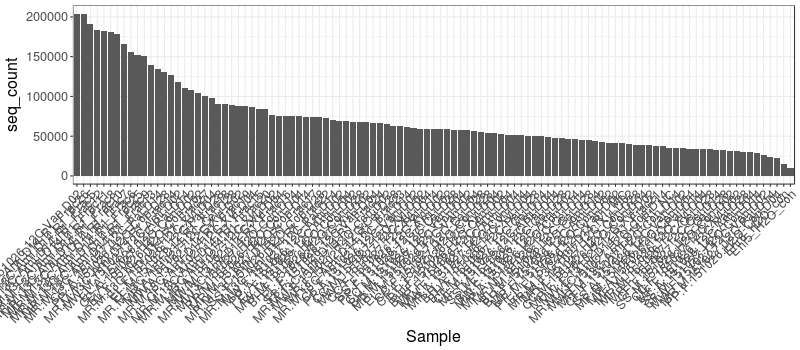

In [34]:
%%R -i df_seq_cnt -w 800 -h 350
# plotting all

df_seq_cnt$seq_count = as.numeric(df_seq_cnt$seq_count)


df_seq_cnt = df_seq_cnt %>% 
    #mutate(H2O = grepl('_F0$', Sample)) %>%
    mutate(rank = min_rank(seq_count)) %>%
    arrange(desc(rank))

df_seq_cnt$Sample = factor(df_seq_cnt$Sample, levels=df_seq_cnt$Sample)

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [36]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 40000,]

                        Sample seq_count rank
83     MR.F.151027.12C-Xyl.D02     39918   25
84     CC.M.151027.H2O-Con.D28     39214   24
85     MP.F.151026.H2O-Con.D04     38796   23
86     MW.F.151027.12C-Xyl.D02     38446   22
87  MR.M.13C-Ami.D14.R1_Frac21     38275   21
88     MW.F.151027.H2O-Con.D14     37447   20
89      MR.M.13C-Ami.D14.R1_NC     35719   19
90     CF.F.151027.H2O-Con.D14     34860   18
91     SS.A.151026.12C-Van.D02     34820   17
92     MF.M.151026.H2O-Con.D04     34161   16
93     MP.A.151026.12C-Pal.D14     33928   15
94     MF.M.151026.12C-Xyl.D04     33848   14
95     MP.M.151026.12C-Cel.D28     33544   13
96     MR.F.151027.12C-Cel.D14     33135   12
97     CF.F.151027.12C-Cel.D28     32376   11
98     SS.M.151026.H2O-Con.D02     31672   10
99     CC.F.151027.12C-Xyl.D02     31445    9
100    MF.F.151026.12C-Pal.D28     29674    8
101    SS.A.151026.12C-Ami.D04     29566    7
102    CF.M.151027.H2O-Con.D14     29151    6
103    MW.F.151027.12C-Van.D02    